# Creation of a ML program on the COVID dataset
In this final part of the COVID project, we will create machine learning programs, optimize them, and pick the best according to our expectations.

What will be seen here:
- ML algorithme: RandomForestClassifier, AdaBoostClassifier, SVM, KNeighborsClassifier
- Creation of a pipeline and its utilization with a GridSearchCV
- Utilization of RandomizedSearchCV
## Importing the relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()

## Load the dataset

In [2]:
path = 'C://Users//foucardguimax//Desktop//PortFolio//Dataset.xlsx'
raw_data = pd.read_excel(path)
df = raw_data.copy()

pd.set_option('display.max_row', df.shape[1])
pd.set_option('display.max_columns', df.shape[1])

In [4]:
missing_rate = df.isna().sum()/df.shape[0]

blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)])
viral_columns = list(df.columns[(missing_rate < 0.8) & (missing_rate > 0.75)])
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

df = df[key_columns + blood_columns + viral_columns]

## TrainTest

In [5]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df, test_size = 0.2, random_state = 0)

## Encoding

In [6]:
def encoding(df):
    code = {'positive':1, 'negative':0, 'detected':1, 'not_detected':0}
    for col in df.select_dtypes('object'):
        df[col] = df[col].map(code)

    return(df)

def imputation(df):
    return(df.dropna())

def feature_engineering(df):
    df['is_scik'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis = 1)
    return(df)

def preprocessing(df):
    
    df = encoding(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis = 1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return(X, y)

In [7]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


C:\Users\foucardguimax\Desktop\PYTHON\Python3.7\Machine-learnia\Regression\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\foucardguimax\Desktop\PYTHON\Python3.7\Machine-learnia\Regression\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Modelling

In [27]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [28]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring='f1', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis = 1), label = 'train score')
    plt.plot(N, val_score.mean(axis = 1), label = 'validation score')
    plt.legend()

In [29]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10)) #Pipeline that contains our preprocessing actions

In [30]:
# Here we put the pipelines before our models
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0)) #At this point we need to normalize our data. With Tree based algorithme it is not needed, but here it is.
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())
# All the hyperparameters are the basics one for now.

In [34]:
list_of_models = {'RandomForest':RandomForest, 'AdaBoost':AdaBoost, 'SVM':SVM, 'KNN':KNN}

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71  

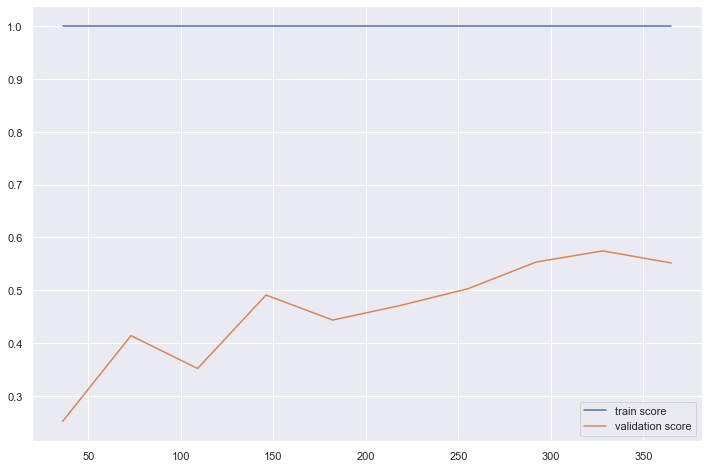

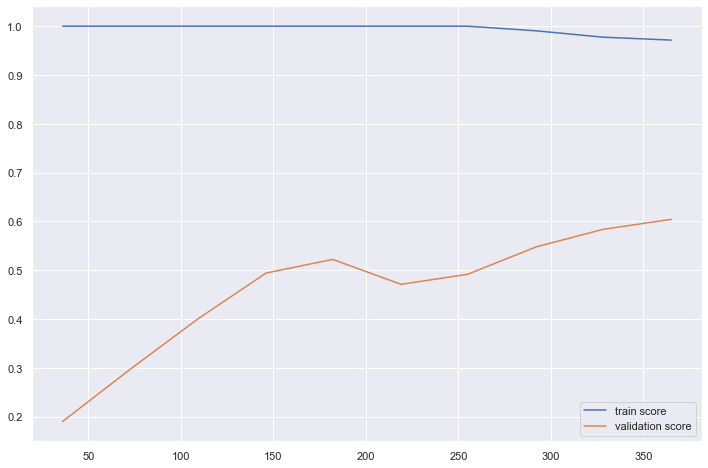

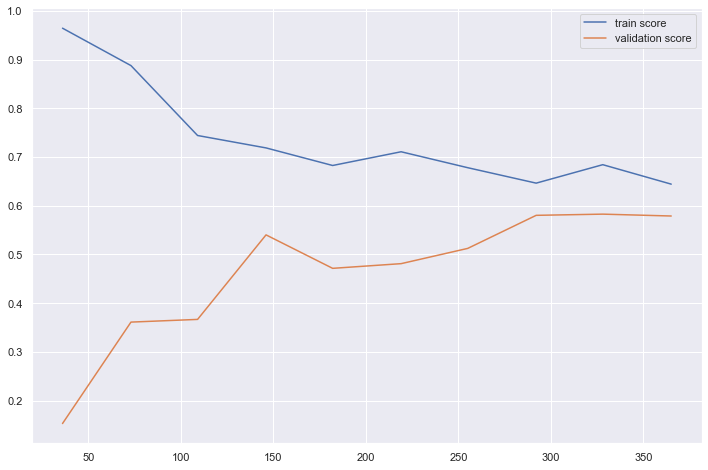

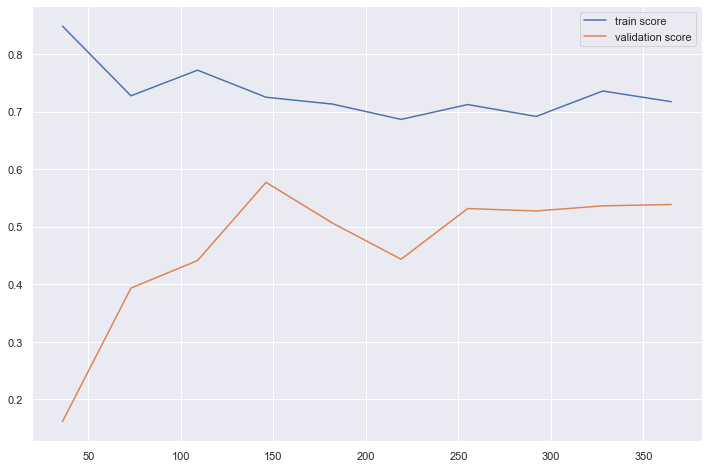

In [36]:
for name, model in list_of_models.items():
    print(name)
    evaluation(model)

## Optimization
As usual, we will use GridSearchCV for the optimization. We will create a grid for the SVM model because it was one of the best regarding the recall, the F1-score and the trainset fitting.

In [37]:
from sklearn.model_selection import GridSearchCV

In [39]:
SVM #simply by calling this model, we can get all the hyperparameters and select the one we want to put on the grid

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('polynomialfeatures',
                                  PolynomialFeatures(degree=2,
                                                     include_bias=False,
                                                     interaction_only=False,
                                                     order='C')),
                                 ('selectkbest',
                                  SelectKBest(k=10,
                                              score_func=<function f_classif at 0x0000018BA7B21AF8>))],
                          verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', ke

In [42]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],
                'svc__C':[1,10,100,1000]}

In [43]:
grid = GridSearchCV(SVM, hyper_params, scoring='recall', cv=4)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__C': 1000, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



The model is now a bit better. Let's put it through our evaluation function.

[[92  3]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



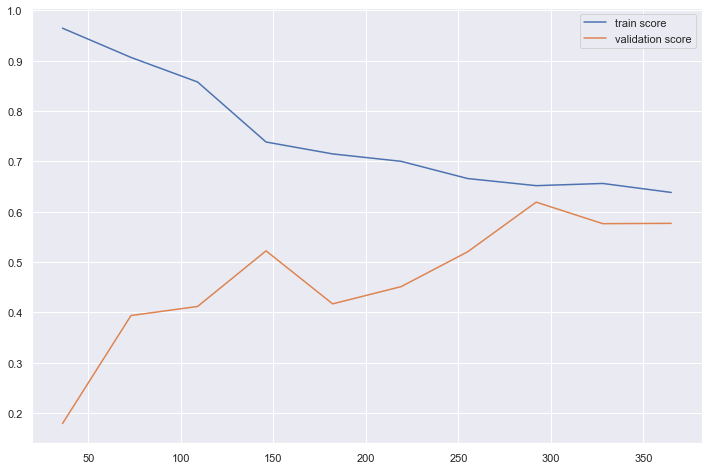

In [44]:
evaluation(grid)

This is nice, the model looks able to generalize results as it is not overfitted and that the curves are getting closer and closer.

We've seen that it is possible to build a better model by using a GridSearchCV, so why not try all the hyperparameters on a grid and select the best ? Because it will take a lot of time. Instead what we can do is using a RandomizedSearchCV that will only try some of the parameters of the grid randomly.

In [72]:
hyper_params_2 = {'svc__gamma':[1e-3, 1e-4],
                'svc__C':[1,10,100,1000],
               'pipeline__polynomialfeatures__degree': [2,3,4],
               'pipeline__selectkbest__k':range(40,60)}

In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
random_grid = RandomizedSearchCV(SVM, hyper_params_2, scoring='recall', cv=4, n_iter = 40)

random_grid.fit(X_train, y_train)

print(random_grid.best_params_)

y_pred = random_grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.0001, 'svc__C': 1000, 'pipeline__selectkbest__k': 55, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111



[[89  6]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        95
           1       0.57      0.50      0.53        16

    accuracy                           0.87       111
   macro avg       0.74      0.72      0.73       111
weighted avg       0.87      0.87      0.87       111



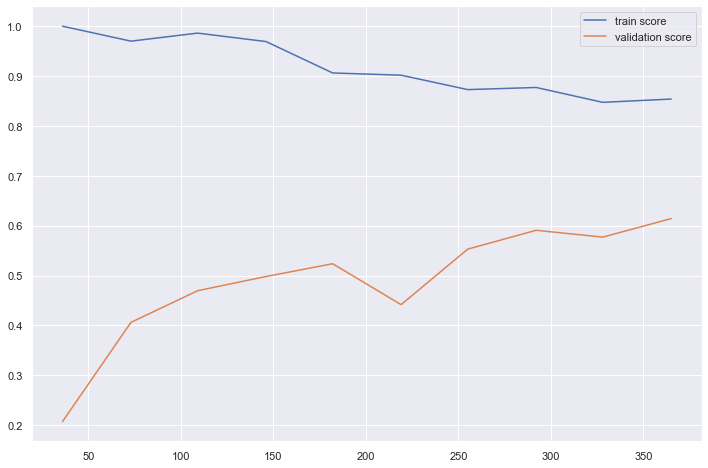

In [75]:
evaluation(random_grid)

## Precision Recall Curve

In [76]:
from sklearn.metrics import precision_recall_curve

In [78]:
precision, recall, threshold = precision_recall_curve(y_test, random_grid.best_estimator_.decision_function(X_test))

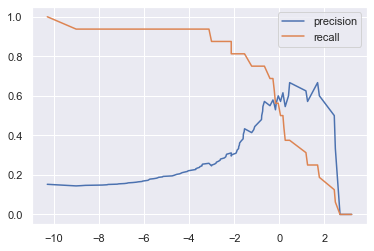

In [80]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

What this graph means:
- If we select a threshold of -12, the recall is 1. This means that every single patient infected with the COVID was detected by the model. But this is something easy to do if the model classifies all the patitents as positives. That's the reason why the precision is so low.
- We need to find the best tradeoff between the recall and the precision. We want the best recall for the best precision. Usually, this is the F1-score.

In [81]:
def ultimate_model(model, X, threshold =0):
    return(model.decision_function(X) > threshold)

In [91]:
y_pred = ultimate_model(grid.best_estimator_, X_test, threshold=-1)

In [92]:
from sklearn.metrics import f1_score, recall_score
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6875
0.5789473684210527


That's not bad at all ! The model classified almost 70% of the patients correctly.